In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import xgboost
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesClassifier,
)
from scipy.stats import randint, uniform

## Process weather data

In [2]:
weather_data = pd.read_csv("../data/processed_weather_data_leuven.csv")

In [3]:
# Dropping index csv column
weather_data.drop(["Unnamed: 0"], inplace=True, axis=1)

In [4]:
# Format time stamp
weather_data["time"] = pd.to_datetime(weather_data["time"])
weather_data["date"] = weather_data["time"].dt.date
weather_data["hour"] = weather_data["time"].dt.hour
weather_data["month"] = weather_data["time"].dt.month
weather_data["weekday"] = weather_data["time"].dt.strftime("%a")

In [5]:
weather_data = (
    weather_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()
)

C:\Users\jef-w\AppData\Local\Temp\ipykernel_16608\1371198228.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weather_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()


In [6]:
# Dropping weathercode because signal should be contained in other data + excessive amount of dummies + unseen values
weather_data = weather_data.drop("weathercode", axis=1)

## Process airquality data



In [7]:
air_quality_data = pd.read_csv("../data/processed_air_quality_data.csv")

In [8]:
# Dropping index csv column
air_quality_data.drop(["Unnamed: 0"], inplace=True, axis=1)

In [9]:
# extract from timestamp
air_quality_data["dt"] = pd.to_datetime(air_quality_data["dt"])
air_quality_data["date"] = air_quality_data["dt"].dt.date
air_quality_data["hour"] = air_quality_data["dt"].dt.hour
air_quality_data["month"] = air_quality_data["dt"].dt.month
air_quality_data["weekday"] = air_quality_data["dt"].dt.strftime("%a")

In [10]:
air_quality_data = (
    air_quality_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()
)

C:\Users\jef-w\AppData\Local\Temp\ipykernel_16608\3314303586.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  air_quality_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()


## Processing file 40 data, merge all files

In [11]:
# Noise data
file40 = pd.read_csv("../data/processed_file40_data.csv")

In [12]:
# Dropping index csv column
file40.drop(["Unnamed: 0"], inplace=True, axis=1)

In [13]:
# Convert the 'result_timestamp' column to a datetime data type
file40["result_timestamp"] = pd.to_datetime(file40["result_timestamp"])
file40["date"] = file40["result_timestamp"].dt.date
file40["hour"] = file40["result_timestamp"].dt.hour
file40["month"] = file40["result_timestamp"].dt.month
file40["weekday"] = file40["result_timestamp"].dt.strftime("%a")

In [14]:
file40 = (
    file40.groupby(["object_id", "date", "hour", "month", "weekday"])
    .mean()
    .reset_index()
)

C:\Users\jef-w\AppData\Local\Temp\ipykernel_16608\3127493086.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


In [15]:
data_model_v2 = file40.merge(
    air_quality_data,
    how="inner",
    left_on=["date", "hour", "month", "weekday"],
    right_on=["date", "hour", "month", "weekday"],
)

In [16]:
data_model_v2 = data_model_v2.merge(
    weather_data,
    how="inner",
    left_on=["date", "hour", "month", "weekday"],
    right_on=["date", "hour", "month", "weekday"],
)

In [17]:
## split train, test data
train_df, val_df = train_test_split(data_model_v2, test_size=0.2, random_state=7)

In [18]:
data_model_v2

,object_id,date,hour,month,weekday,laf005_per_hour,laf01_per_hour,laf05_per_hour,laf10_per_hour,laf25_per_hour,...,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,windgusts_10m
0,255439,2022-01-04,0,1,Tue,77.2,75.4,70.8,68.9,66.0,...,7.0,100.0,100.0,0.0,0.0,0.0,0.0,17.8,238.0,26.3
1,255440,2022-01-04,0,1,Tue,77.8,75.3,67.9,64.8,60.1,...,7.0,100.0,100.0,0.0,0.0,0.0,0.0,17.8,238.0,26.3
2,255441,2022-01-04,0,1,Tue,76.8,73.0,66.6,63.7,59.6,...,7.0,100.0,100.0,0.0,0.0,0.0,0.0,17.8,238.0,26.3
3,255442,2022-01-04,0,1,Tue,82.5,78.0,67.6,64.3,59.0,...,7.0,100.0,100.0,0.0,0.0,0.0,0.0,17.8,238.0,26.3
4,255443,2022-01-04,0,1,Tue,78.6,74.9,67.2,64.1,59.4,...,7.0,100.0,100.0,0.0,0.0,0.0,0.0,17.8,238.0,26.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49446,255442,2022-12-31,23,12,Sat,77.7,74.7,67.2,64.6,60.4,...,2.0,1.0,90.0,0.0,0.0,0.0,0.0,38.8,217.0,71.6
49447,255443,2022-12-31,23,12,Sat,73.6,71.1,65.4,63.0,59.1,...,2.0,1.0,90.0,0.0,0.0,0.0,0.0,38.8,217.0,71.6
49448,255444,2022-12-31,23,12,Sat,71.3,69.2,64.1,61.7,57.4,...,2.0,1.0,90.0,0.0,0.0,0.0,0.0,38.8,217.0,71.6
49449,280324,2022-12-31,23,12,Sat,70.7,68.5,63.9,62.1,59.6,...,2.0,1.0,90.0,0.0,0.0,0.0,0.0,38.8,217.0,71.6


## Process independent variables and apply column transformer

In [19]:
target_variable = [col for col in train_df.columns if col.startswith("laf")]
target_variable

['laf005_per_hour',
 'laf01_per_hour',
 'laf05_per_hour',
 'laf10_per_hour',
 'laf25_per_hour',
 'laf50_per_hour',
 'laf75_per_hour',
 'laf90_per_hour',
 'laf95_per_hour',
 'laf98_per_hour',
 'laf99_per_hour',
 'laf995_per_hour']

In [20]:
y_train = train_df[target_variable]
y_val = val_df[target_variable]

X_train = train_df.drop(target_variable + ["date"], axis=1)
X_val = val_df.drop(target_variable + ["date"], axis=1)

In [21]:
one_hot_var = ["hour", "month", "weekday", "object_id"]
numerical_var = [col for col in X_train.columns if col not in one_hot_var]

In [22]:
t = ColumnTransformer(
    transformers=[
        ("OneHot", OneHotEncoder(handle_unknown="ignore"), one_hot_var),
        ("StandardScaler", StandardScaler(), numerical_var),
    ]
)

# fit the encoder
t.fit(X_train, y_train)

ColumnTransformer(transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['hour', 'month', 'weekday', 'object_id']),
                                ('StandardScaler', StandardScaler(),
                                 ['pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2',
                                  'nh3', 'temperature_2m',
                                  'relativehumidity_2m', 'dewpoint_2m',
                                  'apparent_temperature', 'pressure_msl',
                                  'surface_pressure', 'precipitation', 'rain',
                                  'snowfall', 'cloudcover', 'cloudcover_low',
                                  'cloudcover_mid', 'cloudcover_high',
                                  'shortwave_radiation', 'direct_radiation',
                                  'diffuse_radiation',
                                  'direct_normal_irradiance', 'windspeed_10m',
                                  'winddirection_10m', 'windgusts_10m'])])

In [23]:
# Save encoder
pickle.dump(t, open("../model/model_noise_level_file40/encoder.pkl", "wb"))

In [24]:
# create pandas DataFrame from dense matrix
X_train = pd.DataFrame(t.fit_transform(X_train), columns=t.get_feature_names_out())
X_val = pd.DataFrame(t.transform(X_val), columns=t.get_feature_names_out())

## Predict laf50

Here we predict the 50th percentile LAF level per hour. We use RandomizedSearchCV to find the optimal hyperparameters for RandomForest, GardientBoosting, and XGB. </br>
The same methodology is later applied to find models for the 25th and 75th percentile LAF. </br>
As so often, XGB performs best in both train and validation sets, and is therefore our model of choice.

In [25]:
if os.path.isfile("../model/model_noise_level_file40/laf50_per_hour_dict"):
    model_params = {
        "random_forest": {
            "model": RandomForestRegressor(),
            "params": {
                "n_estimators": randint(50, 100),
                "max_depth": randint(3, 50),
                "max_features": ["auto", "sqrt"],
                "min_samples_split": randint(2, 20),
                "min_samples_leaf": randint(1, 10),
                "bootstrap": [True, False],
            },
        },
        "gradient_boosting": {
            "model": GradientBoostingRegressor(),
            "params": {
                "n_estimators": randint(50, 100),
                "learning_rate": uniform(0.01, 0.5),
                "max_depth": randint(1, 10),
                "min_samples_split": randint(2, 20),
                "min_samples_leaf": randint(1, 10),
            },
        },
        "xgboost": {
            "model": xgboost.XGBRegressor(),
            "params": {
                "n_estimators": randint(50, 100),
                "learning_rate": uniform(0.01, 0.5),
                "max_depth": randint(1, 10),
                "min_child_weight": randint(1, 10),
                "gamma": uniform(0, 1),
                "reg_alpha": uniform(0, 1),
                "reg_lambda": uniform(0, 1),
            },
        },
    }

# Using RandomizedSearch CV to tune hyperparams, if tuning was done in the past results are loaded from .pckl file
if os.path.isfile("../model/model_noise_level_file40/laf50_per_hour_dict.pkl"):
    print(
        "Params have already been searched and saved, so instead we just load the file"
    )
    params_dict = pickle.load(
        open("../model/model_noise_level_file40/laf50_per_hour_dict.pkl", "rb")
    )
else:
    # Define the model parameters
    params_dict = {}

    # Loop through each model in model_params and run RandomizedSearchCV
    for model_name, model_info in model_params.items():
        print("Running RandomizedSearchCV for {}...".format(model_name))

        # Create a RandomizedSearchCV object for the current model
        model = model_info["model"]
        param_dist = model_info["params"]
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            n_iter=10,
            cv=5,
            n_jobs=1,
            random_state=7,
        )

        # Fit the RandomizedSearchCV object to the data
        random_search.fit(X_train, y_train["laf50_per_hour"])
        params_dict[model_name] = random_search.best_params_

        # Print the best parameters and score
        for model_name, model_info in model_params.items():
            print("Best parameters for {}: ".format(model_name), random_search.best_params_)
            print("Best score for {}: ".format(model_name), random_search.best_score_)
            print("\n")

Params have already been searched and saved, so instead we just load the file


In [26]:
# Save optimal param dictionary
pickle.dump(
    params_dict, open("../model/model_noise_level_file40/laf50_per_hour_dict.pkl", "wb")
)

In [27]:
gb_params = params_dict["gradient_boosting"]

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train, y_train["laf50_per_hour"])

train_preds = gb.predict(X_train)
val_preds = gb.predict(X_val)

print(
    "Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laf50_per_hour"]))
)
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laf50_per_hour"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laf50_per_hour"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laf50_per_hour"]))

Train RMSE: 1.5910264458354786
Val RMSE: 2.4345394590473357
Train MAE: 1.1122357742340818
Val MAE: 1.6399656640092948


In [28]:
rf_params = params_dict["random_forest"]

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train, y_train["laf50_per_hour"])

train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laf50_per_hour"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laf50_per_hour"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laf50_per_hour"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laf50_per_hour"]))

Train RMSE: 1.2752919994675074
Val RMSE: 2.5218920672648397
Train MAE: 0.8410768935471777
Val MAE: 1.6529127253665743


In [29]:

xgb_params = params_dict["xgboost"]

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, y_train["laf50_per_hour"])

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laf50_per_hour"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laf50_per_hour"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laf50_per_hour"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laf50_per_hour"]))

Train RMSE: 1.18945351883048
Val RMSE: 2.2361555984891868
Train MAE: 0.8379353141784668
Val MAE: 1.484125030497523


Text(0, 0.5, 'y val')

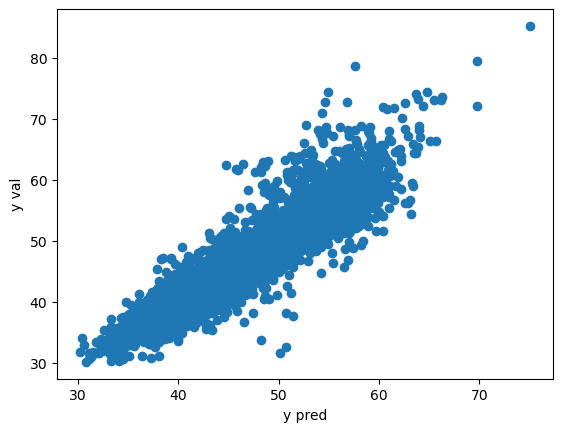

In [30]:
plt.scatter(val_preds, y_val["laf50_per_hour"])
plt.xlabel("y pred")
plt.ylabel("y val")

In [31]:
r2_score(val_preds, y_val["laf50_per_hour"])

0.8650905000296837

<BarContainer object of 15 artists>

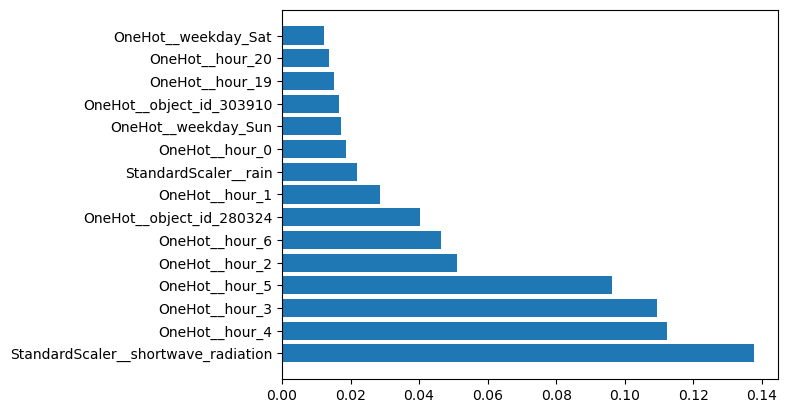

In [32]:
feature_importances = xgb.feature_importances_
sorted_idx = feature_importances.argsort()[::-1]
sorted_importances = feature_importances[sorted_idx[0:15]]
sorted_columns = list(X_train.columns[sorted_idx[0:15]])
plt.barh(sorted_columns, sorted_importances)

In [33]:
sum(sorted_importances)

0.7373472917824984

In [34]:
# Saving best model
pickle.dump(xgb, open("../model/model_noise_level_file40/xgb_laf50_per_hour.pkl", "wb"))

## Predict Laf 25/75

In [35]:
targets = ["laf25_per_hour", "laf75_per_hour"]
model_params_dict = {}
for target in targets:
    if os.path.isfile(f"../model//model_noise_level_file40/{target}_dict.pkl"):
        print(
            "Params have already been searched and saved, so instead we just load the file"
        )
        model_params_dict[target] = pickle.load(
            open(f"../model/model_noise_level_file40/{target}_dict.pkl", "rb")
        )
    else:
        # Define the model parameters
        model_params = {
            "random_forest": {
                "model": RandomForestRegressor(),
                "params": {
                    "n_estimators": randint(50, 100),
                    "max_depth": randint(3, 50),
                    "max_features": ["auto", "sqrt"],
                    "min_samples_split": randint(2, 20),
                    "min_samples_leaf": randint(1, 10),
                    "bootstrap": [True, False],
                },
            },
            "gradient_boosting": {
                "model": GradientBoostingRegressor(),
                "params": {
                    "n_estimators": randint(50, 100),
                    "learning_rate": uniform(0.01, 0.5),
                    "max_depth": randint(1, 10),
                    "min_samples_split": randint(2, 20),
                    "min_samples_leaf": randint(1, 10),
                },
            },
            "xgboost": {
                "model": xgboost.XGBRegressor(),
                "params": {
                    "n_estimators": randint(50, 100),
                    "learning_rate": uniform(0.01, 0.5),
                    "max_depth": randint(1, 10),
                    "min_child_weight": randint(1, 10),
                    "gamma": uniform(0, 1),
                    "reg_alpha": uniform(0, 1),
                    "reg_lambda": uniform(0, 1),
                },
            },
        }

        params_dict = {}

        # Loop through each model in model_params and run RandomizedSearchCV
        for model_name, model_info in model_params.items():
            print("Running RandomizedSearchCV for {}...".format(model_name))

            # Create a RandomizedSearchCV object for the current model
            model = model_info["model"]
            param_dist = model_info["params"]
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_dist,
                n_iter=10,
                cv=5,
                n_jobs=1,
                random_state=7,
            )

            # Fit the RandomizedSearchCV object to the data
            random_search.fit(X_train, y_train[target])

            # Print the best parameters and score
            params_dict[model_name] = random_search.best_params_
            print(
                "Best parameters for {}: ".format(model_name),
                random_search.best_params_,
            )
            print("Best score for {}: ".format(model_name), random_search.best_score_)
            print("\n")

        model_params_dict[target] = params_dict
        pickle.dump(
            params_dict, open(f"../model/model_noise_level_file40/{target}_dict.pkl", "wb")
        )

Params have already been searched and saved, so instead we just load the file
Params have already been searched and saved, so instead we just load the file


### Running gb, rf, xgb for laf25/laf75 including RMSE/MAE scorings

In [36]:
gb_models = {}
for target in targets:
    gb_params = model_params_dict[target]["gradient_boosting"]

    gb = GradientBoostingRegressor(**gb_params, random_state=7)

    gb.fit(X_train, y_train[target])

    train_preds = gb.predict(X_train)
    val_preds = gb.predict(X_val)

    print(
        f"Train RMSE of model {target}:",
        np.sqrt(mean_squared_error(train_preds, y_train[target])),
    )
    print(
        f"Val RMSE of model {target}:",
        np.sqrt(mean_squared_error(val_preds, y_val[target])),
    )
    print(
        f"Train MAE of model {target}:",
        mean_absolute_error(train_preds, y_train[target]),
    )
    print(f"Val MAE of model {target}:", mean_absolute_error(val_preds, y_val[target]))
    gb_models[target] = gb

Train RMSE of model laf25_per_hour: 1.6464051304378413
Val RMSE of model laf25_per_hour: 2.5301549636041663
Train MAE of model laf25_per_hour: 1.1424637667217936
Val MAE of model laf25_per_hour: 1.6732161142674475
Train RMSE of model laf75_per_hour: 1.515076174432507
Val RMSE of model laf75_per_hour: 2.2952170205463416
Train MAE of model laf75_per_hour: 1.0643538094293763
Val MAE of model laf75_per_hour: 1.5380855104541549


In [37]:
rf_models = {}
for target in targets:

    rf_params = model_params_dict[target]["random_forest"]

    rf = RandomForestRegressor(**rf_params, random_state=7)

    rf.fit(X_train, y_train[target])

    train_preds = rf.predict(X_train)
    val_preds = rf.predict(X_val)

    print(
        f"Train RMSE of model {target}:",
        np.sqrt(mean_squared_error(train_preds, y_train[target])),
    )
    print(
        f"Val RMSE of model {target}:",
        np.sqrt(mean_squared_error(val_preds, y_val[target])),
    )
    print(
        f"Train MAE of model {target}:",
        mean_absolute_error(train_preds, y_train[target]),
    )
    print(f"Val MAE of model {target}:", mean_absolute_error(val_preds, y_val[target]))
    rf_models[target] = rf

Train RMSE of model laf25_per_hour: 1.3343436082200673
Val RMSE of model laf25_per_hour: 2.614682575605048
Train MAE of model laf25_per_hour: 0.8595036569176765
Val MAE of model laf25_per_hour: 1.6890048416060537
Train RMSE of model laf75_per_hour: 1.1939518835962668
Val RMSE of model laf75_per_hour: 2.4149456025382845
Train MAE of model laf75_per_hour: 0.792195278854871
Val MAE of model laf75_per_hour: 1.5974126272406886


In [38]:
xgb_models = {}
for target in targets:

    xgb_params = model_params_dict[target]["xgboost"]

    xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)
    xgb.fit(X_train, y_train[target])

    train_preds = xgb.predict(X_train)
    val_preds = xgb.predict(X_val)

    print(
        f"Train RMSE of model {target}:",
        np.sqrt(mean_squared_error(train_preds, y_train[target])),
    )
    print(
        f"Val RMSE of model {target}:",
        np.sqrt(mean_squared_error(val_preds, y_val[target])),
    )
    print(
        f"Train MAE of model {target}:",
        mean_absolute_error(train_preds, y_train[target]),
    )
    print(f"Val MAE of model {target}:", mean_absolute_error(val_preds, y_val[target]))
    xgb_models[target] = xgb

Train RMSE of model laf25_per_hour: 1.3132165034954806
Val RMSE of model laf25_per_hour: 2.3784306800521966
Train MAE of model laf25_per_hour: 0.9100933854861979
Val MAE of model laf25_per_hour: 1.5573840484449442
Train RMSE of model laf75_per_hour: 1.1277934455739353
Val RMSE of model laf75_per_hour: 2.2013469117740856
Train MAE of model laf75_per_hour: 0.7945391835385315
Val MAE of model laf75_per_hour: 1.440866175373769


In [39]:
# Saving best model (XGB)
for target in targets:
    pickle.dump(
        xgb_models[target],
        open(f"../model/model_noise_level_file40/xgb_{target}.pkl", "wb"),
    )

# Alternative feature Matricies Models

## Changing features


Here we decided to split up our old feature matrix into 3 new matricies, to evaluate performance on their own. </br>
They are split into "time" (only hour, month, weekday dummies), "weather", and "air-quality" matricies. The "object_id" (location) feature has been left in models

In [40]:
# 3 different feature matrices based on the 3 different main data types (time, weather, air_quality)
time_df = data_model_v2[['object_id', 'hour', 'month', 'weekday']]
time_df.name = "time_df"
weather_df = data_model_v2[['object_id','temperature_2m',
       'relativehumidity_2m', 'dewpoint_2m', 'apparent_temperature',
       'pressure_msl', 'surface_pressure', 'precipitation', 'rain', 'snowfall',
       'cloudcover', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'windspeed_10m', 'winddirection_10m',
       'windgusts_10m']]
weather_df.name = "weather_df"
air_df = data_model_v2[['object_id','pm2_5', 'pm10','co', 'no2', 'o3', 'so2', 'nh3']]
air_df.name = "air_df"
feature_dfs = [time_df, air_df, weather_df]

for df in feature_dfs:
       # Using same split random state as before
       df.train, df.val = train_test_split(df, test_size=0.2, random_state=7)


C:\Users\jef-w\AppData\Local\Temp\ipykernel_16608\1723593949.py:18: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.train, df.val = train_test_split(df, test_size=0.2, random_state=7)


In [41]:
# Building 3 different transformers for the feature matrices

t_time = ColumnTransformer(
    transformers=[
        ("OneHot", OneHotEncoder(handle_unknown="ignore"), time_df.columns)
    ]
)

# fit the encoder
t_time.fit(time_df.train, y_train)
time_df.encoder= t_time

t_air = ColumnTransformer(
    transformers=[
        ("OneHot", OneHotEncoder(handle_unknown="ignore"), ["object_id"]),
        ("StandardScaler", StandardScaler(), ['pm2_5', 'pm10','co', 'no2', 'o3', 'so2', 'nh3']),
    ]
)

# fit the encoder
t_air.fit(air_df.train, y_train)
air_df.encoder = t_air

t_weather = ColumnTransformer (
    transformers=[
        ("OneHot", OneHotEncoder(handle_unknown="ignore"), ["object_id"]),
        ("StandardScaler", StandardScaler(), ['temperature_2m',
       'relativehumidity_2m', 'dewpoint_2m', 'apparent_temperature',
       'pressure_msl', 'surface_pressure', 'precipitation', 'rain', 'snowfall',
       'cloudcover', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'windspeed_10m', 'winddirection_10m',
       'windgusts_10m']),
    ]
)

# fit the encoder
t_weather.fit(weather_df.train, y_train)
weather_df.encoder = t_weather

In [42]:
# create pandas DataFrame from dense matrix

time_df.train = pd.DataFrame((time_df.encoder.fit_transform(time_df.train)).toarray(), columns=time_df.encoder.get_feature_names_out())
time_df.val = pd.DataFrame((time_df.encoder.fit_transform(time_df.val)).toarray(), columns=time_df.encoder.get_feature_names_out())

air_df.train = pd.DataFrame((air_df.encoder.fit_transform(air_df.train)), columns=air_df.encoder.get_feature_names_out())
air_df.val = pd.DataFrame((air_df.encoder.fit_transform(air_df.val)), columns=air_df.encoder.get_feature_names_out())

weather_df.train = pd.DataFrame((weather_df.encoder.fit_transform(weather_df.train)), columns=weather_df.encoder.get_feature_names_out())
weather_df.val = pd.DataFrame((weather_df.encoder.fit_transform(weather_df.val)), columns=weather_df.encoder.get_feature_names_out())


### RF, GB, XGB

In [43]:
model_params_dict = {}

# Checking if Search has been done previously
if os.path.isfile("multiple_features_matrix.pkl"):
    print(
        "Params have already been searched and saved, so instead we just load the file"
    )
    model_params_dict = pickle.load(
        open("multiple_features_matrix.pkl", "rb")
    )
else: 
    for df in feature_dfs:
        # Define the model parameters
        model_params = {
            "random_forest": {
                "model": RandomForestRegressor(),
                "params": {
                    "n_estimators": randint(50, 100),
                    "max_depth": randint(3, 50),
                    "max_features": ["auto", "sqrt"],
                    "min_samples_split": randint(2, 20),
                    "min_samples_leaf": randint(1, 10),
                    "bootstrap": [True, False],
                },
            },
            "gradient_boosting": {
                "model": GradientBoostingRegressor(),
                "params": {
                    "n_estimators": randint(50, 100),
                    "learning_rate": uniform(0.01, 0.5),
                    "max_depth": randint(1, 10),
                    "min_samples_split": randint(2, 20),
                    "min_samples_leaf": randint(1, 10),
                },
            },
            "xgboost": {
                "model": xgboost.XGBRegressor(),
                "params": {
                    "n_estimators": randint(50, 100),
                    "learning_rate": uniform(0.01, 0.5),
                    "max_depth": randint(1, 10),
                    "min_child_weight": randint(1, 10),
                    "gamma": uniform(0, 1),
                    "reg_alpha": uniform(0, 1),
                    "reg_lambda": uniform(0, 1),
                },
            },
        }

        params_dict = {}

        # Loop through each model in model_params and run RandomizedSearchCV
        for model_name, model_info in model_params.items():
            print("Running RandomizedSearchCV for {}...".format(model_name))

            # Create a RandomizedSearchCV object for the current model
            model = model_info["model"]
            param_dist = model_info["params"]
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_dist,
                n_iter=10,
                cv=5,
                n_jobs=1,
                random_state=7,
            )

            # Fit the RandomizedSearchCV object to the data
            random_search.fit(df.train, y_train["laf50_per_hour"])

            # Print the best parameters and score
            params_dict[model_name] = random_search.best_params_
            print(
                "Best parameters for {}: ".format(model_name),
                random_search.best_params_,
            )
            print("Best score for {}: ".format(model_name), random_search.best_score_)
            print("\n")

        model_params_dict[df.name] = params_dict


Params have already been searched and saved, so instead we just load the file


In [44]:
# Saving the optimal hyper params per model and df 
pickle.dump(
    model_params_dict,
    open(f"multiple_features_matrix.pkl", "wb"),
)

In [45]:
from sklearn.linear_model import LinearRegression

used_models = ["random_forest","gradient_boosting","xgboost", "linear_model"]
global_model_dictionary = {}
for df in feature_dfs:
    local_model_dictionary = {}
    for model in used_models: 
        if model != "linear_model":
            model_hyper_params = model_params_dict[df.name][model]

        if model == "gradient_boosting":
            current_model = GradientBoostingRegressor(**model_hyper_params, random_state=7)
        elif model == "random_forest": 
            current_model = RandomForestRegressor(**model_hyper_params, random_state=7)
        elif model == "linear_model":
            current_model = LinearRegression()
        else:
            current_model = xgboost.XGBRegressor(**model_hyper_params, random_state=7)
        
        # Fitting and saving model
        current_model.fit(df.train, y_train["laf50_per_hour"])
        local_model_dictionary[model] = current_model
        
        # Predicting and calculating scores
        train_preds = current_model.predict(df.train)
        val_preds = current_model.predict(df.val)
        test_r2= r2_score(y_train['laf50_per_hour'],train_preds)
        val_r2 = r2_score(y_val['laf50_per_hour'],val_preds)
        
        # Saving and printing scores
        local_model_dictionary[model,"test_r2"] = test_r2
        local_model_dictionary[model,"val_r2"] = val_r2
        
        print(f"{df.name}  {model} model test R²: {test_r2}")
        print(f"{df.name}  {model} model validation R²: {val_r2}")
    # Adding all models to dictionary for respective df
    global_model_dictionary[df.name] = local_model_dictionary

time_df  random_forest model test R²: 0.7353128884386007
time_df  random_forest model validation R²: 0.6873292886254072
time_df  gradient_boosting model test R²: 0.7495409766966195
time_df  gradient_boosting model validation R²: 0.7053143680125107
time_df  xgboost model test R²: 0.7558687504785749
time_df  xgboost model validation R²: 0.7057440903386165
time_df  linear_model model test R²: 0.5824160033901952
time_df  linear_model model validation R²: 0.5686824854507759
air_df  random_forest model test R²: 0.969303152473037
air_df  random_forest model validation R²: 0.6431075909121673
air_df  gradient_boosting model test R²: 0.8556455750688481
air_df  gradient_boosting model validation R²: 0.6136072600291391
air_df  xgboost model test R²: 0.9072063798481554
air_df  xgboost model validation R²: 0.6554381164338823
air_df  linear_model model test R²: 0.1809044195404128
air_df  linear_model model validation R²: 0.1747300662682454
weather_df  random_forest model test R²: 0.9764216268109708
w

### Basic linear model location model

In [46]:
# Translating object_ids back into locations for readability
object_id_dict = {
    255439: "MP 01: Naamsestraat 35 Maxim",
    255440: "MP 02: Naamsestraat 57 Xior",
    255441: "MP 03: Naamsestraat 62 Taste",
    303910: "MP 04: His & Hears",
    255442: "MP 05: Calvariekapel KU Leuven",
    255443: "MP 06: Parkstraat 2 La Filosovia",
    255444: "MP 07: Naamsestraat 81",
    280324: "MP08bis - Vrijthof",
}
location_only = data_model_v2["object_id"].apply(lambda x: object_id_dict[x])
location_train, location_val = train_test_split(location_only, test_size=0.2, random_state=7)

In [47]:
from sklearn.linear_model import LinearRegression
location_train = pd.get_dummies(location_train)
location_val = pd.get_dummies(location_val)

lm  = LinearRegression()
lm.fit(location_train,y_train['laf50_per_hour'])
val_pred = lm.predict(location_val)
print(f"R2 coefficen val: {r2_score(y_val['laf50_per_hour'],val_pred)}")


R2 coefficen val: 0.1220631668268346


In [48]:
## Lm on full set

lm = LinearRegression()
lm.fit(X_train,y_train['laf50_per_hour'])
val_pred = lm.predict(X_val)
print(f"R2 coefficen val: {r2_score(y_val['laf50_per_hour'],val_pred)}")

R2 coefficen val: 0.5751351009288937


# Transforming targets

C:\Users\jef-w\AppData\Local\Temp\ipykernel_16608\1259458630.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = data_model_v2.groupby(["hour"], as_index=False).mean()


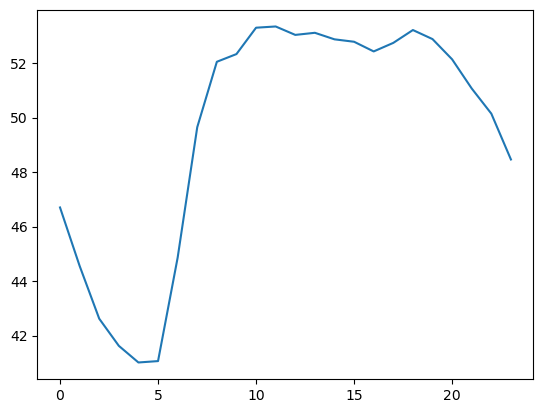

In [49]:
## Plotting old TS
grouped_data = data_model_v2.groupby(["hour"], as_index=False).mean()
plt.plot(grouped_data["hour"],grouped_data["laf50_per_hour"])
plt.show()


In [50]:
test_df  = data_model_v2.copy()
for hour in range(0,24):
    test_df["laf50_per_hour"] = np.where(test_df["hour"]==hour, test_df["laf50_per_hour"]-data_model_v2.loc[data_model_v2["hour"]==hour]["laf50_per_hour"].mean(),test_df["laf50_per_hour"])

C:\Users\jef-w\AppData\Local\Temp\ipykernel_16608\1572623187.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = test_df.groupby(["hour"], as_index=False).mean()


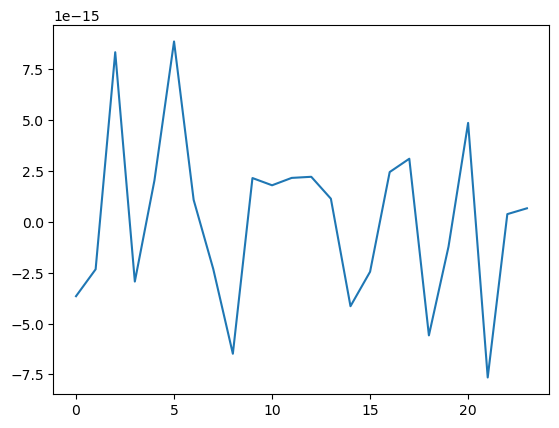

In [51]:
## Plotting New TS
grouped_data = test_df.groupby(["hour"], as_index=False).mean()
plt.plot(grouped_data["hour"],grouped_data["laf50_per_hour"])
plt.show()
